---
title: |
    Supplementary Material for: Soundscape Perception Indices (SPI)
description: |
  Code accompanying the paper: "Soundscape descriptors in eighteen languages: translation and validation through listening experiments
author:
  - name: Andrew Mitchell
    email: andrew.mitchell.18@ucl.ac.uk
    affiliations: 
        - id: ucl-iede
          name: University College London
          department: Institute for Environmental Design and Engineering
          address: Central House, 14 Upper Woburn Place
          city: London
          state: UK
          postal-code: WC1H 0NN
    attributes:
        corresponding: true
    orcid: 0000-0003-0978-5046
  - name: Francesco Aletta
    email: f.aletta@ucl.ac.uk
    orcid: 0000-0003-0351-3189
    affiliations:
        - ref: ucl-iede
format:
  elsevier-pdf:
    echo: true
    keep-tex: true
    keep-ipynb: true
    journal:
      name: Journal of the Acoustical Society of America
      formatting: preprint
      model: 3p
      cite-style: authoryear

bibliography: FellowshipRefs.bib

date: last-modified
---

# Supplementary Material

## Multi-objective Optimization to Derive an SPI target

To set up the optimisation task, we first need to express the parameter space and any constraints. Since our goal is to identify an optimised soundscape target distribution, the parameters we will search over are:

- $\xi = (\xi_x, \xi_y)$,  $-1 \leq \xi \leq 1$
- $\Omega = \begin{pmatrix} var(x) & cov(x, y) \\ cov(y, x) & var(y) \end{pmatrix}$
  - $0 \leq var() \leq 1$
  - $-1 \leq cov() \leq 1$
  - $\Omega$ must be symmetric and positive definite
- $\alpha = (\alpha_x, \alpha_y)$, $-5 \leq \alpha \leq 5$
- $-1 \leq x, y \leq 1$
In `pymoo`, each objective function is supposed to be minimized. Therefore, we need to convert both SPI and r() to minimize problems.

- min $-r(ranks_{quality}, ranks_{target})$
- min $-mean(SPI_{target}(X_i))$

The final objective function is:

- $f_1 = -r(ranks_{quality}, ranks_{target})$
- $f_2 = -mean(SPI_{target}(X_i))$

So our variables to optimize are:

- $-1 \leq \xi_x \leq 1$
- $-1 \leq \xi_y \leq 1$
- $0 \leq var(x) \leq 1$
- $0 \leq var(y) \leq 1$
- $-1 \leq cov(x, y) \leq 1$
- $-5 \leq \alpha_x \leq 5$
- $-5 \leq \alpha_y \leq 5$

Constraint:
- $\Omega$ must be symmetric and positive definite
  - `np.linalg.eigvals(omega) > 0`

We then define the objective functions based on the two goals given above. For each step in the algorithm with a given trial set of parameters, a target distribution will be produced, the SPI for each test location assessed according to the protocol described in Section~\ref{sec-method}, and the resulting set of SPI scores and ranking will be scored using the objective functions. Goal (1) is assessed by calculating the Spearman rank correlation between the \emph{a priori} ranking and the SPI ranking:

In [1]:
#| warning: false

import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import soundscapy as sspy
from soundscapy.surveys.survey_utils import LANGUAGE_ANGLES, PAQ_IDS

import optimize_target as ot
from MultiSkewNorm import MultiSkewNorm

warnings.filterwarnings("ignore")

/workspaces/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspaces/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/workspaces/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [2]:
# Load latest ISD dataset
# data = sspy.isd.load_zenodo()
# Load latest ISD dataset

data = sspy.isd.load()
data, excl_data = sspy.isd.validate(data)
data = data.query("Language != 'cmn'")

# Exclude RegentsParkJapan outliers
# excl_id = list(data.query(
    # "LocationID == 'RegentsParkJapan'"
    # ).query("ISOEventful > 0.72 | ISOEventful < -0.5").index)
# Excluded RegentsParkFields outliers
# excl_id = excl_id + list(data.query(
    # "LocationID == 'RegentsParkFields' and ISOPleasant < 0").index) # Helicopters
excl_id = [652, 706, 548, 550, 551, 553, 569, 580, 609, 618, 623, 636, 643]
data.drop(excl_id, inplace=True)
data

,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,RA_cp90_Max,RA_cp95_Max,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max
0,CarloV,CarloV2,2CV12,1434,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29
1,CarloV,CarloV2,2CV12,1435,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29
2,CarloV,CarloV2,2CV13,1430,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
3,CarloV,CarloV2,2CV13,1431,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
4,CarloV,CarloV2,2CV13,1432,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,Noorderplantsoen,Noorderplantsoen1,NP161,61,2020-03-11 12:42:00,2020-03-11 12:55:00,NaN,NaN,nld,nldSSIDv1,...,2.54,2.00,-3.17,-11.97,59.64,37.87,26.54,6.33,-9.79,-10.34
1694,Noorderplantsoen,Noorderplantsoen1,NP162,63,2020-03-11 12:39:00,2020-03-11 13:00:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,Noorderplantsoen,Noorderplantsoen1,NP162,62,2020-03-11 12:54:00,2020-03-11 12:58:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1696,Noorderplantsoen,Noorderplantsoen1,NP162,64,2020-03-11 12:56:00,2020-03-11 12:59:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate ISOPleasant and ISOEventful coordinates

Here we use the adjusted angles from Aletta et al. (2024) for each language included.

In [3]:
for i, row in data.iterrows():
    lang = row["Language"]
    angles = LANGUAGE_ANGLES[lang]
    iso_pl, iso_ev = (
        sspy.surveys.processing._adj_iso_pl(row[PAQ_IDS], angles, scale=4),
        sspy.surveys.processing._adj_iso_ev(row[PAQ_IDS], angles, scale=4),
    )
    data.loc[i, "ISOPleasant"] = iso_pl
    data.loc[i, "ISOEventful"] = iso_ev

In [4]:
# Separate out parks and non-parks

parks = [
    "RegentsParkFields",
    "RegentsParkJapan",
    "Noorderplantsoen",
    "StPaulsCross",
    "MiradorSanNicolas",
    "RussellSq",
    "Noorderplantsoen",
    "MonumentoGaribaldi",
    "CampoPrincipe",
]

not_parks = [
    "MarchmontGarden",
    "PancrasLock",
    "TateModern",
    "PlazaBibRambla",
    "SanMarco",
    "StPaulsRow",
    "CarloV",
    "CamdenTown",
    "EustonTap",
    "TorringtonSq",
]

park_data = data.query("LocationID in @parks")
not_park_data = data.query("LocationID in @not_parks")

rank_on = "sss01"

In [5]:
# Creating a somewhat arbitrary ranking of parks
park_quality = pd.DataFrame(
    park_data.groupby("LocationID")[rank_on].mean().sort_values(ascending=False)
)
park_quality["Rank"] = range(1, len(park_quality) + 1)
park_quality

,sss01,Rank
LocationID,,
RegentsParkJapan,4.617978,1
RegentsParkFields,4.467290,2
CampoPrincipe,4.345455,3
MonumentoGaribaldi,4.156250,4
RussellSq,4.020548,5
MiradorSanNicolas,3.964286,6
StPaulsCross,3.803030,7
Noorderplantsoen,2.412371,8


## `pymoo` Multi-objective Optimization

Defining the optimization problem:

- max $r(ranks_{quality}, ranks_{target})$
- max $mean(SPI_{target}(X_i))$

where $r$ is the rank correlation coefficient, $ranks_{quality}$ and $ranks_{target}$ are the ranks of the quality and target values, and $SPI_{target}(X_i)$ is the SPI for a given target on the data for the $i$-th location. Therefore we are trying to achieve the best correlation between the desired ranking and the ranking produced by $SPI_{target}$ *and* to achieve the highest mean $SPI_{target}$.

$ranks_{quality}$ is pre-defined. $ranks_{target}$ is calculated by sorting the target values and assigning ranks to them. $SPI_{target}$ is calculated for each location and target.


`target_success(target, pre_ranks, data)`

`target` = `MultiSkewNorm`($\xi$, $\Omega$, $\alpha$) parameters

- $\xi = (\xi_x, \xi_y)$,  $-1 \leq \xi \leq 1$
- $\Omega = \begin{pmatrix} var(x) & cov(x, y) \\ cov(y, x) & var(y) \end{pmatrix}$
  - $0 \leq var() \leq 1$
  - $-1 \leq cov() \leq 1$
  - $\Omega$ must be symmetric and positive definite
- $\alpha = (\alpha_x, \alpha_y)$, $-5 \leq \alpha \leq 5$
- $-1 \leq x, y \leq 1$
In `pymoo`, each objective function is supposed to be minimized. Therefore, we need to convert both SPI and r() to minimize problems.

- min $-r(ranks_{quality}, ranks_{target})$
- min $-mean(SPI_{target}(X_i))$

The final objective function is:

- $f_1 = -r(ranks_{quality}, ranks_{target})$
- $f_2 = -mean(SPI_{target}(X_i))$

So our variables to optimize are:

- $-1 \leq \xi_x \leq 1$
- $-1 \leq \xi_y \leq 1$
- $0 \leq var(x) \leq 1$
- $0 \leq var(y) \leq 1$
- $-1 \leq cov(x, y) \leq 1$
- $-5 \leq \alpha_x \leq 5$
- $-5 \leq \alpha_y \leq 5$

Constraint:
- $\Omega$ must be symmetric and positive definite
  - `np.linalg.eigvals(omega) > 0`

### Problem Definition

In [19]:
import pathos
from pymoo.core.callback import Callback
from pymoo.core.problem import ElementwiseProblem, StarmapParallelization
from pymoo.visualization.scatter import Scatter
from pyrecorder.recorder import Recorder
from pyrecorder.writers.streamer import Streamer
from pyrecorder.writers.video import Video
from pymoo.decomposition.asf import ASF


class MyProblem(ElementwiseProblem):
    def __init__(self, data, ranking, **kwargs):
        super().__init__(
            n_var=7,
            n_obj=2,
            n_constr=0,
            xl=np.array([-1, -1, 0, 0, -1, -50, -50]),
            xu=np.array([1, 1, 0.5, 0.5, 1, 50, 50]),
            n_eq_constr=1,
            elementwise_evaluation=True,
            **kwargs,
        )

        self.data = data
        self.ranking = ranking

    def _evaluate(self, X, out, *args, **kwargs):
        # Check if the matrix is positive definite
        h = 1 - int(
            np.all(np.linalg.eigvals(np.array([[X[2], X[4]], [X[4], X[3]]])) > 0)
        )
        out["H"] = h
        if h != 0:
            out["F"] = np.column_stack([0, 0])
            return
        else:
            tgt = MultiSkewNorm()
            tgt.define_dp(
                np.array([X[0], X[1]]),
                np.array([[X[2], X[4]], [X[4], X[3]]]),
                np.array([X[5], X[6]]),
            )
            tgt.sample()
            r, wspi, spi_ranks, target = ot.target_success(tgt, self.ranking, self.data)

            f1 = -r[0]
            f2 = -wspi / 100

            out["F"] = np.column_stack([f1, f2])


class VideoCallback(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.rec = Recorder(Streamer(sleep=0.1))

    def notify(self, algorithm):
        sc = Scatter(
            title="Gen %s" % algorithm.n_gen,
            labels=["spearman", "WSPI"],
        )
        sc.add(algorithm.pop.get("F"))
        sc.do()
        self.rec.record()

In [20]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultMultiObjectiveTermination

algorithm = NSGA2(
    pop_size=150,
    sampling=FloatRandomSampling(),
    crossover=SBX(),
    mutation=PM(),
    eliminate_duplicates=True,
    # callback=VideoCallback()
)

termination = DefaultMultiObjectiveTermination(n_max_gen=100)


### Park Quality optimization

In [21]:
# initialize the thread pool and create the runner
mp = pathos.helpers.mp
n_process = 12
pool = mp.Pool(n_process)
runner = StarmapParallelization(pool.starmap)

park_problem = MyProblem(
    data=park_data, ranking=park_quality.sort_index()["Rank"], elementwise_runner=runner
)

park_res = minimize(
    park_problem, algorithm, termination, seed=42, save_history=True, verbose=True
)

pool.close()

park_F = park_res.F
park_X = park_res.X

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      2 |  0.000000E+00 |  0.7599240000 |             - |             -
     2 |      300 |      2 |  0.000000E+00 |  0.3732960000 |  0.1111111111 |         ideal
     3 |      450 |      4 |  0.000000E+00 |  0.000000E+00 |  0.2500000000 |         ideal
     4 |      600 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0335522234 |             f
     5 |      750 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0680302031 |         ideal
     6 |      900 |      9 |  0.000000E+00 |  0.000000E+00 |  0.2047687061 |         ideal
     7 |     1050 |     11 |  0.000000E+00 |  0.000000E+00 |  0.2929936306 |         nadir
     8 |     1200 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0966259235 |         ideal
     9 |     1350 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0782387648 |         ideal
    10 |     1500 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0611556026 |         ideal

In [15]:
weights = np.array([0.5, 0.5])
decomp = ASF()

with Recorder(Video("park_nsga2.mp4")) as rec:
    for entry in park_res.history:
        # Get the approximated ideal and nadir points
        approx_ideal = park_res.F.min(axis=0)
        approx_nadir = park_res.F.max(axis=0)

        # Normalize the obtained front
        nF = (entry.pop.get("F") - approx_ideal) / (approx_nadir - approx_ideal)
        park_I = decomp(nF, weights).argmin()
        sc = Scatter(title="Generation: %s" % entry.n_gen)
        sc.add(entry.pop.get("F"))
        sc.add(entry.pop.get("F")[park_I], color="red", s=30)
        sc.do()
        rec.record()


with Recorder(Video("park_nsga2_sspy.mp4")) as rec:
    for entry in park_res.history:
        # Get the approximated ideal and nadir points
        approx_ideal = park_res.F.min(axis=0)
        approx_nadir = park_res.F.max(axis=0)

        # Normalize the obtained front
        nF = (entry.pop.get("F") - approx_ideal) / (approx_nadir - approx_ideal)
        park_I = decomp(nF, weights).argmin()
        park_X = entry.pop.get("X")[park_I]
        park_tgt = MultiSkewNorm()
        park_tgt.define_dp(
            np.array([park_X[0], park_X[1]]),
            np.array([[park_X[2], park_X[4]], [park_X[4], park_X[3]]]),
            np.array([park_X[5], park_X[6]]),
        )
        park_tgt.sample()
        ss = sspy.plotting.density_plot(
            data=pd.DataFrame({
                "ISOPleasant": park_tgt.sample_data[:,0],
                "ISOEventful": park_tgt.sample_data[:,1],
            }),
            # x=park_tgt.sample_data[:,0],
            # y=park_tgt.sample_data[:,1],
            title="Generation: %s" % entry.n_gen,
        )
        rec.record()

In [16]:
#| label: fig-pymoo-park-pareto
#| fig-cap: Multi-objective optimization Pareto front resulting from fitting to the Park ranking.

from pymoo.decomposition.asf import ASF

# Get the approximated ideal and nadir points
approx_ideal = park_res.F.min(axis=0)
approx_nadir = park_res.F.max(axis=0)

# Normalize the obtained front
nF = (park_res.F - approx_ideal) / (approx_nadir - approx_ideal)

weights = np.array([0.48, 0.52])
decomp = ASF()

park_I = decomp(nF, weights).argmin()
print("Best regarding decomposition: Point %s - %s" % (park_I, park_res.F[park_I]))


Best regarding decomposition: Point 2 - [-0.71428571 -1.89225   ]


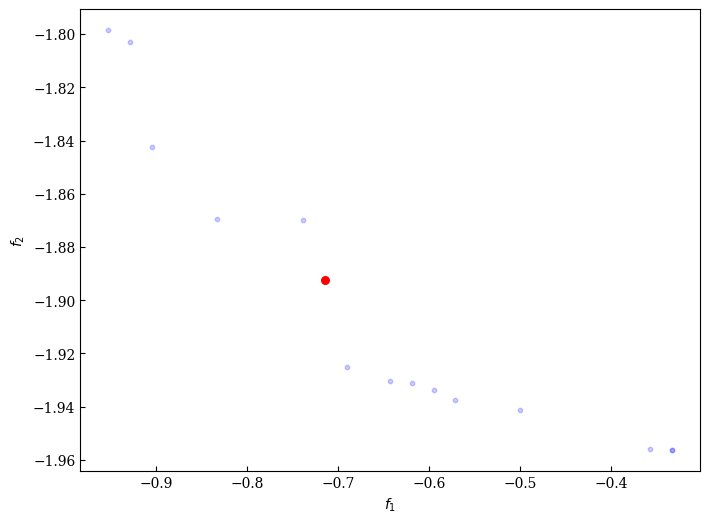

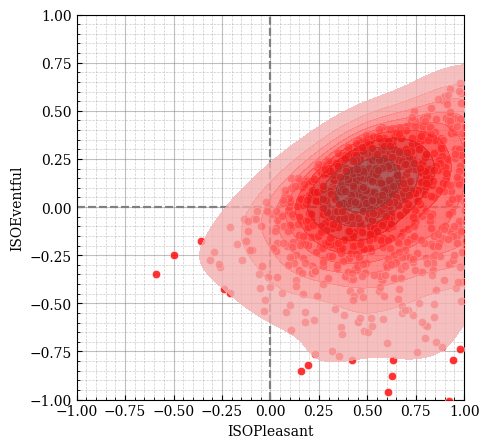

In [17]:
#| label: fig-pymoo-parks
#| fig-cap: "NSGA-II optimization to learn the MSN parameters which produce the Park ranking."
#| fig-subcap:
#|   - "Multi-objective optimization Pareto front. The selected solution is indicated in red."
#|   - "SCM distribution of the derived target distribution."
#| layout-ncol: 2
import matplotlib.pyplot as plt

park_X = park_res.X[park_I]
park_tgt = MultiSkewNorm()
park_tgt.define_dp(
    np.array([park_X[0], park_X[1]]),
    np.array([[park_X[2], park_X[4]], [park_X[4], park_X[3]]]),
    np.array([park_X[5], park_X[6]]),
)
park_tgt.sample()

# print(park_tgt.summary())

plot = Scatter()
plot.add(park_res.F, color="blue", alpha=0.2, s=10)
plot.add(park_res.F[park_I], color="red", s=30)
plot.do()
# plot.apply(lambda ax: ax.arrow(0, 0, 0.5, 0.5, color='black',
#                                head_width=0.01, head_length=0.01, alpha=0.4))
plot.show()
plt.show()



# park_tgt.sspy_plot()
df = pd.DataFrame(park_tgt.sample_data, columns=["ISOPleasant", "ISOEventful"])
sspy.plotting.density_plot(
    df, color='red', title=None
)
plt.show()

In [12]:
print(park_tgt.summary())

Fitted from direct parameters.
Direct Parameters:
xi:    [0.418 0.284]
omega: [[ 0.164 -0.044]
 [-0.044  0.152]]
alpha: [ 16.628 -30.187]


None
None
